In [1]:
import jax
import jax.numpy as np
import numpy as onp

from scipy.stats import chi2

from jax.scipy.stats import bernoulli, norm
from jax.scipy.special import logsumexp
from jax import random, grad, jit, value_and_grad, vmap
from jax import tree_multimap, tree_map
from jax.flatten_util import ravel_pytree

from collections import namedtuple
from copy import deepcopy
from cycler import cycler

from functools import partial

from matplotlib import cm, rc
import matplotlib.pyplot as plt

from synthetic_data import toy_logistic_data

%matplotlib inline

In [ ]:
# Make sure to creat this path
PATH = './figures'

In [2]:
# matplotlib Global Settings
rc('lines', lw=3)
rc('axes', lw=1.2, titlesize='large', labelsize='x-large')
rc('legend', fontsize='x-large')
rc('font', family='serif')

In [3]:
LocScaleParameters = namedtuple('LocScaleParameters', ['loc', 'log_scale'])

In [4]:
def gaussian_sample(params, key, num_samples=1):
    mean = params.loc
    std_dev = np.exp(params.log_scale)
    samples = mean[np.newaxis, ...] + random.normal(key, shape=(num_samples, *mean.shape)) * std_dev
    return samples

In [5]:
def gaussian_log_pdf(params, x):
    assert x.shape == params.loc.shape, "Input must have the same shape as the event. Use vmap for batching."
    return np.sum(norm.logpdf(x, loc=params.loc, scale=np.exp(params.log_scale)))

def batch_log_pdf(params, x):
    log_pdf = vmap(gaussian_log_pdf, in_axes=(None, 0))(params, x)
    return log_pdf

In [6]:
LinearModel = namedtuple('LinearModel', ('w', 'b'))
Hyperparameters = namedtuple('Hyperparameters', ('likelihood_parameters', 'prior_parameters'))

In [7]:
def create_linear_model(features):
    w = LocScaleParameters(loc=np.zeros((features, )), log_scale=np.zeros((features, )))
    b = LocScaleParameters(loc=np.zeros(()), log_scale=np.zeros(()))
    return LinearModel(w=w, b=b)

def logistic_regression_prior(features):
    w = LocScaleParameters(loc=np.zeros((features, )), log_scale=np.zeros((features, )))
    b = LocScaleParameters(loc=np.zeros(()), log_scale=np.zeros(()))
    return LinearModel(w=w, b=b)

In [8]:
def model_map(fn, model):
    model_type = type(model)
    new_model = model_type(*map(fn, model))
    return new_model

In [9]:
def model_multimap(fn, model, extra_args):
    model_type = type(model)
    new_model = model_type(*map(fn, model, *extra_args))
    return new_model

In [10]:
def predict(samples, x):
    w = samples.w
    b = samples.b
    logits = np.dot(w, x) + b
    return jax.nn.sigmoid(logits)

In [11]:
def bernoulli_logpmf(k, p):
    tol = 1e-7
    p = np.clip(p, tol, 1 - tol)
    return k * np.log(p) + (1 - k) * np.log(1 - p)

In [12]:
def neg_likelihood(samples, data):
    x, y = data
    y_pred = vmap(predict, in_axes=(None, 0))(samples, x).T # SxB
    logprob = vmap(bernoulli_logpmf, in_axes=(None, 0))(y, y_pred)
    return -np.sum(logprob, axis=1)

In [13]:
def reparam_log_likelihood(samples, data):
    return - neg_likelihood(samples, data)

In [14]:
def vi_objective(variational_parameters, hyperparameters, data, key, num_samples=1):
    
    sampling_keys = random.split(key, num=2)
    
    samples = model_multimap(lambda x, y: gaussian_sample(x, y, num_samples=num_samples),
                             variational_parameters, (sampling_keys, ))
    
    exp_log_likelihood = reparam_log_likelihood(samples, data)
    
    prior_parameters = hyperparameters.prior_parameters
    
    exp_log_prior = model_multimap(batch_log_pdf, prior_parameters, (samples, ))
    exp_log_posterior = model_multimap(batch_log_pdf, variational_parameters, (samples, ))
    
    elbo_samples = (exp_log_likelihood - sum(exp_log_posterior) + sum(exp_log_prior))
    
    return - np.mean(elbo_samples)

In [15]:
def marginal_likelihood(variational_parameters, hyperparameters, data, key, num_samples=1):
    
    sampling_keys = random.split(key, num=2)
    
    samples = model_multimap(lambda x, y: gaussian_sample(x, y, num_samples=num_samples),
                             variational_parameters, (sampling_keys, ))
    
    exp_log_likelihood = reparam_log_likelihood(samples, data)
    
    prior_parameters = hyperparameters.prior_parameters
    
    exp_log_prior = model_multimap(batch_log_pdf, prior_parameters, (samples, ))
    exp_log_posterior = model_multimap(batch_log_pdf, variational_parameters, (samples, ))
    
    elbo_samples = (exp_log_likelihood - sum(exp_log_posterior) + sum(exp_log_prior))
    
    return logsumexp(elbo_samples) - np.log(num_samples)

In [16]:
marginal_likelihood = jit(marginal_likelihood, static_argnums=(4, ))

In [17]:
def varKL_objective(variational_parameters, hyperparameters, data, key, num_samples=1):
    
    sampling_keys = random.split(key, num=2)
    
    samples = model_multimap(lambda x, y: jax.lax.stop_gradient(gaussian_sample(x, y, num_samples=num_samples)),
                             variational_parameters, (sampling_keys, ))
    
    exp_log_likelihood = reparam_log_likelihood(samples, data)
    
    prior_parameters = hyperparameters.prior_parameters
    
    exp_log_prior = model_multimap(batch_log_pdf, prior_parameters, (samples, ))
    exp_log_posterior = model_multimap(batch_log_pdf, variational_parameters, (samples, ))
    
    elbo_samples = (exp_log_likelihood - sum(exp_log_posterior) + sum(exp_log_prior))
    
    return 0.5 * np.var(elbo_samples, ddof=1)

In [18]:
varKL_loss_value_and_grad = jit(value_and_grad(varKL_objective), static_argnums=(1, 2, 4))

In [19]:
def bbvi_objective(variational_parameters, hyperparameters, data, key, num_samples=1):
    
    sampling_keys = random.split(key, num=2)
    
    samples = model_multimap(lambda x, y: gaussian_sample(x, y, num_samples=num_samples),
                             variational_parameters, (sampling_keys, ))
    
    samples = jax.lax.stop_gradient(samples)
    
    exp_log_likelihood = reparam_log_likelihood(samples, data)
    
    prior_parameters = hyperparameters.prior_parameters
    
    exp_log_prior = model_multimap(batch_log_pdf, prior_parameters, (samples, ))
    exp_log_posterior = model_multimap(batch_log_pdf, variational_parameters, (samples, ))
    
    elbo_samples = (exp_log_likelihood - sum(exp_log_posterior) + sum(exp_log_prior))
    loss_samples = jax.lax.stop_gradient(elbo_samples) * sum(exp_log_posterior)
    return - np.mean(loss_samples)

In [20]:
bbvi_loss_value_and_grad = jit(value_and_grad(bbvi_objective), static_argnums=(1, 2, 4))

In [21]:
def log_posterior(variational_parameters, data, key, num_samples=1):
    sampling_keys = random.split(key, num=2)
    
    samples = model_multimap(lambda x, y: gaussian_sample(x, y, num_samples=num_samples),
                             variational_parameters, (sampling_keys, ))
    
    samples = jax.lax.stop_gradient(samples)
    
    exp_log_posterior = model_multimap(batch_log_pdf, variational_parameters, (samples, ))
    return - np.mean(sum(exp_log_posterior))

In [22]:
def gd_update(param, grad, learning_rate):
    return param - learning_rate * grad

In [23]:
def compute_delta(control_variates, function_values):
    coeff = []
    for i in range(control_variates.shape[1]):
        cov = onp.cov(control_variates[:, i] ** 2, function_values, rowvar=False)
        var = np.var(control_variates[:, i])
        coeff.append(cov[0, 1] / var)
    return np.stack(coeff)

In [24]:
def main(dimension, epoch=10):
    w, b, X, Y = toy_logistic_data(100, 82, input_size=dimension)

    data = (X, Y[:, 0])
    
    logistic_regression_prior_params = logistic_regression_prior(dimension)
    logistic_regression_posterior = create_linear_model(dimension)
    hyperparameters = Hyperparameters(likelihood_parameters=None, prior_parameters=logistic_regression_prior_params)

    score_function = jit(grad(log_posterior), static_argnums=(1, 3))

    var_kl = jit(value_and_grad(varKL_objective), static_argnums=(1, 2, 4))
    vi_loss_value_and_grad = jit(value_and_grad(vi_objective), static_argnums=(1, 2, 4))

    learning_rate = 0.001
    key = random.PRNGKey(42)
    for i in range(epoch):
        _, key = random.split(key)
#         loss, gradients = vi_loss_value_and_grad(logistic_regression_posterior, hyperparameters, data, key, 5)
        loss, gradients = var_kl(logistic_regression_posterior, hyperparameters, data, key, 5)
        update_fn = partial(gd_update, learning_rate=learning_rate)
        updates = tree_multimap(update_fn, logistic_regression_posterior, (gradients))
        logistic_regression_posterior = LinearModel(*updates)

        print("Loss =", loss)

    key = random.PRNGKey(42)

    def sample_grads(params, key, num_samples):
        single_sample_cv = []
        single_sample_values = []
        for i in range(num_samples):
            key, _ = random.split(key)
            ## Single samples CV
            cv = score_function(params, data, key, 1)
            cv, _ = ravel_pytree(cv)
            single_sample_cv.append(cv)
            ## Single sample value
            v, _ = vi_loss_value_and_grad(params, hyperparameters, data, key, 1)
            single_sample_values.append(v)

        single_sample_cv = np.stack(single_sample_cv)
        single_sample_values = np.stack(single_sample_values)
        return single_sample_cv, single_sample_values

    def run(params, key, num_samples):
        results_dict = {}
        samples = sample_grads(params, key, num_samples)
        single_samples_cv, single_sample_values = samples


        delta = compute_delta(single_samples_cv, single_sample_values)

        results_dict['delta'] = delta
        results_dict['single_sample_values'] = single_sample_values

        return results_dict

    results_dict = run(logistic_regression_posterior, key, num_samples=2000)
    results_dict['log_likelihood'] = marginal_likelihood(logistic_regression_posterior, 
                                                         hyperparameters, data, key, 10000)
    return results_dict

In [25]:
# EPOCHS = [0, 1, 5, 10, 20, 50, 100]
EPOCHS = [0, 10, 50, 100, 500, 1000]
# DIMENSIONS = [2, 5, 20, 50, 100]
DIMENSIONS = [20, 50, 100, 200]
results = []
for dim in DIMENSIONS:
    runs = []
    for epoch in EPOCHS:
        runs.append(main(dim, epoch))
    results.append(runs)

/home/ayman/miniconda3/envs/var-kl/lib/python3.8/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Loss = 276.5679
Loss = 467.83395
Loss = 305.2055
Loss = 535.82623
Loss = 312.22696
Loss = 315.1169
Loss = 475.42255
Loss = 339.84134
Loss = 242.17023
Loss = 790.18195
Loss = 276.5679
Loss = 467.83395
Loss = 305.2055
Loss = 535.82623
Loss = 312.22696
Loss = 315.1169
Loss = 475.42255
Loss = 339.84134
Loss = 242.17023
Loss = 790.18195
Loss = 129.88585
Loss = 597.5165
Loss = 428.4144
Loss = 170.74728
Loss = 454.43707
Loss = 462.01648
Loss = 268.74545
Loss = 2512.8442
Loss = 811.9035
Loss = 375.63092
Loss = 189.55226
Loss = 317.49643
Loss = 118.08819
Loss = 97.29662
Loss = 1621.9974
Loss = 90.44726
Loss = 156.22705
Loss = 70.048134
Loss = 303.14136
Loss = 342.36548
Loss = 185.26888
Loss = 85.08753
Loss = 69.79272
Loss = 44.464214
Loss = 220.86974
Loss = 521.84375
Loss = 32.621254
Loss = 70.51166
Loss = 70.43225
Loss = 257.1224
Loss = 375.49255
Loss = 93.332115
Loss = 300.1215
Loss = 315.9155
Loss = 590.4779
Loss = 363.64883
Loss = 4.6151752
Loss = 282.98706
Loss = 43.171215
Loss = 196.13199

Loss = 1.6373737
Loss = 3.4047945
Loss = 5.0859146
Loss = 2.8284085
Loss = 5.9613533
Loss = 6.8598747
Loss = 2.4066424
Loss = 1.1249324
Loss = 3.6530125
Loss = 0.91762847
Loss = 7.3331985
Loss = 1.5791265
Loss = 11.673152
Loss = 1.2229874
Loss = 3.0767832
Loss = 28.189604
Loss = 8.90796
Loss = 3.0751114
Loss = 5.1684904
Loss = 1.5050545
Loss = 8.810499
Loss = 3.7854729
Loss = 20.451414
Loss = 7.382445
Loss = 6.8128934
Loss = 0.6821998
Loss = 1.9198445
Loss = 2.416608
Loss = 3.0732946
Loss = 2.1758862
Loss = 3.430595
Loss = 2.3050892
Loss = 4.7202506
Loss = 4.394302
Loss = 1.3742738
Loss = 2.3081417
Loss = 1.9294593
Loss = 1.3892851
Loss = 1.592741
Loss = 4.635025
Loss = 10.181414
Loss = 2.4668376
Loss = 3.4852424
Loss = 1.4921895
Loss = 3.6258953
Loss = 2.618038
Loss = 1.862486
Loss = 1.6248407
Loss = 4.1354136
Loss = 2.9494472
Loss = 2.84473
Loss = 8.500108
Loss = 3.5474207
Loss = 2.4739206
Loss = 7.937743
Loss = 4.0899987
Loss = 9.405694
Loss = 1.0926068
Loss = 6.044612
Loss = 19.067

Loss = 1.6373737
Loss = 3.4047945
Loss = 5.0859146
Loss = 2.8284085
Loss = 5.9613533
Loss = 6.8598747
Loss = 2.4066424
Loss = 1.1249324
Loss = 3.6530125
Loss = 0.91762847
Loss = 7.3331985
Loss = 1.5791265
Loss = 11.673152
Loss = 1.2229874
Loss = 3.0767832
Loss = 28.189604
Loss = 8.90796
Loss = 3.0751114
Loss = 5.1684904
Loss = 1.5050545
Loss = 8.810499
Loss = 3.7854729
Loss = 20.451414
Loss = 7.382445
Loss = 6.8128934
Loss = 0.6821998
Loss = 1.9198445
Loss = 2.416608
Loss = 3.0732946
Loss = 2.1758862
Loss = 3.430595
Loss = 2.3050892
Loss = 4.7202506
Loss = 4.394302
Loss = 1.3742738
Loss = 2.3081417
Loss = 1.9294593
Loss = 1.3892851
Loss = 1.592741
Loss = 4.635025
Loss = 10.181414
Loss = 2.4668376
Loss = 3.4852424
Loss = 1.4921895
Loss = 3.6258953
Loss = 2.618038
Loss = 1.862486
Loss = 1.6248407
Loss = 4.1354136
Loss = 2.9494472
Loss = 2.84473
Loss = 8.500108
Loss = 3.5474207
Loss = 2.4739206
Loss = 7.937743
Loss = 4.0899987
Loss = 9.405694
Loss = 1.0926068
Loss = 6.044612
Loss = 19.067

Loss = 1.198857
Loss = 0.7601861
Loss = 2.5065417
Loss = 5.8443437
Loss = 0.41617376
Loss = 0.36586896
Loss = 0.26008365
Loss = 0.654472
Loss = 2.2007732
Loss = 0.8628434
Loss = 0.3723215
Loss = 0.7034848
Loss = 1.7185814
Loss = 0.91263443
Loss = 0.9755554
Loss = 0.4512874
Loss = 1.5466822
Loss = 3.3928895
Loss = 2.3435042
Loss = 2.0375795
Loss = 1.9464588
Loss = 0.5119979
Loss = 1.7234322
Loss = 1.1558008
Loss = 1.1733388
Loss = 0.16247077
Loss = 0.46435124
Loss = 1.2463554
Loss = 1.1266762
Loss = 1.5560087
Loss = 0.49878907
Loss = 0.29999453
Loss = 0.20897031
Loss = 1.1015856
Loss = 1.1609837
Loss = 0.5806001
Loss = 0.9059576
Loss = 0.96860427
Loss = 0.4573771
Loss = 0.64325917
Loss = 0.3215452
Loss = 1.2377124
Loss = 0.40723547
Loss = 2.023377
Loss = 0.537176
Loss = 1.527187
Loss = 3.3919356
Loss = 0.6478076
Loss = 137.05759
Loss = 218.94083
Loss = 915.5612
Loss = 149.19296
Loss = 913.17957
Loss = 1266.435
Loss = 322.8792
Loss = 545.9233
Loss = 642.8612
Loss = 415.82776
Loss = 137.0

Loss = 25.805258
Loss = 18.032747
Loss = 11.186832
Loss = 40.806164
Loss = 18.427876
Loss = 31.582258
Loss = 51.17609
Loss = 18.212145
Loss = 9.528112
Loss = 54.341373
Loss = 2.603991
Loss = 63.460022
Loss = 8.863291
Loss = 26.703985
Loss = 7.2149553
Loss = 28.56291
Loss = 30.739346
Loss = 25.159348
Loss = 18.305748
Loss = 27.079765
Loss = 10.743031
Loss = 25.418905
Loss = 48.569736
Loss = 19.139343
Loss = 29.52641
Loss = 10.680528
Loss = 31.84046
Loss = 32.290363
Loss = 25.845184
Loss = 14.629354
Loss = 26.975111
Loss = 14.67023
Loss = 10.349981
Loss = 7.3074293
Loss = 4.6096687
Loss = 12.005141
Loss = 11.595503
Loss = 4.8014417
Loss = 4.76322
Loss = 21.572088
Loss = 8.220874
Loss = 22.777258
Loss = 28.135687
Loss = 11.529631
Loss = 2.9633567
Loss = 7.6210146
Loss = 15.4491625
Loss = 70.52328
Loss = 38.115494
Loss = 46.600727
Loss = 4.6177506
Loss = 28.754692
Loss = 15.619134
Loss = 46.742992
Loss = 23.257153
Loss = 5.4731884
Loss = 8.937863
Loss = 10.7347765
Loss = 57.013103
Loss = 1

Loss = 11.186832
Loss = 40.806164
Loss = 18.427876
Loss = 31.582258
Loss = 51.17609
Loss = 18.212145
Loss = 9.528112
Loss = 54.341373
Loss = 2.603991
Loss = 63.460022
Loss = 8.863291
Loss = 26.703985
Loss = 7.2149553
Loss = 28.56291
Loss = 30.739346
Loss = 25.159348
Loss = 18.305748
Loss = 27.079765
Loss = 10.743031
Loss = 25.418905
Loss = 48.569736
Loss = 19.139343
Loss = 29.52641
Loss = 10.680528
Loss = 31.84046
Loss = 32.290363
Loss = 25.845184
Loss = 14.629354
Loss = 26.975111
Loss = 14.67023
Loss = 10.349981
Loss = 7.3074293
Loss = 4.6096687
Loss = 12.005141
Loss = 11.595503
Loss = 4.8014417
Loss = 4.76322
Loss = 21.572088
Loss = 8.220874
Loss = 22.777258
Loss = 28.135687
Loss = 11.529631
Loss = 2.9633567
Loss = 7.6210146
Loss = 15.4491625
Loss = 70.52328
Loss = 38.115494
Loss = 46.600727
Loss = 4.6177506
Loss = 28.754692
Loss = 15.619134
Loss = 46.742992
Loss = 23.257153
Loss = 5.4731884
Loss = 8.937863
Loss = 10.7347765
Loss = 57.013103
Loss = 12.662927
Loss = 9.417342
Loss = 1.

Loss = 5.302321
Loss = 8.132356
Loss = 1.1574148
Loss = 1.6002789
Loss = 1.5075724
Loss = 8.282766
Loss = 5.472854
Loss = 3.9565861
Loss = 11.338869
Loss = 2.5784388
Loss = 3.8286657
Loss = 4.1025863
Loss = 10.510484
Loss = 5.8100414
Loss = 13.52633
Loss = 3.8719063
Loss = 1.8062547
Loss = 7.426929
Loss = 2.1348794
Loss = 4.925864
Loss = 9.5032
Loss = 4.4117813
Loss = 5.779357
Loss = 4.6257925
Loss = 14.30839
Loss = 11.741101
Loss = 7.3014264
Loss = 6.6218395
Loss = 0.6636652
Loss = 16.688221
Loss = 12.6927395
Loss = 6.1635127
Loss = 13.794986
Loss = 4.0274057
Loss = 3.4855735
Loss = 10.301973
Loss = 1.6091938
Loss = 8.163028
Loss = 4.5274844
Loss = 1.8556803
Loss = 30.856419
Loss = 24.363686
Loss = 1.8915931
Loss = 6.740526
Loss = 25.08482
Loss = 3.2866936
Loss = 4.8288536
Loss = 17.960173
Loss = 7.253313
Loss = 11.435213
Loss = 10.17173
Loss = 15.373938
Loss = 6.4609685
Loss = 3.065929
Loss = 2.9345524
Loss = 3.8839562
Loss = 4.113863
Loss = 7.0673637
Loss = 6.552204
Loss = 8.565735


Loss = 171.86346
Loss = 29.425474
Loss = 73.73226
Loss = 42.914318
Loss = 277.33905
Loss = 201.54253
Loss = 54.45399
Loss = 122.44093
Loss = 49.85644
Loss = 150.7164
Loss = 67.7427
Loss = 121.38894
Loss = 154.51106
Loss = 328.11804
Loss = 96.97239
Loss = 459.7072
Loss = 60.926983
Loss = 113.881645
Loss = 405.6715
Loss = 162.49191
Loss = 77.876755
Loss = 129.26064
Loss = 154.40182
Loss = 36.12775
Loss = 100.99914
Loss = 59.700428
Loss = 25.073662
Loss = 75.6515
Loss = 321.1496
Loss = 184.48137
Loss = 234.46255
Loss = 72.69224
Loss = 53.05891
Loss = 75.24183
Loss = 103.23888
Loss = 84.219215
Loss = 62.818047
Loss = 22.341066
Loss = 199.76093
Loss = 64.457184
Loss = 84.778175
Loss = 117.49423
Loss = 22.82048
Loss = 54.033447
Loss = 65.31205
Loss = 46.58339
Loss = 21.04929
Loss = 197.26532
Loss = 206.52058
Loss = 23.444824
Loss = 55.461952
Loss = 45.86978
Loss = 17.144037
Loss = 134.53046
Loss = 19.48992
Loss = 271.97818
Loss = 70.02254
Loss = 105.3267
Loss = 24.432457
Loss = 23.872925
Los

Loss = 124.86308
Loss = 144.68642
Loss = 363.82806
Loss = 28.173107
Loss = 260.8924
Loss = 171.86346
Loss = 29.425474
Loss = 73.73226
Loss = 42.914318
Loss = 277.33905
Loss = 201.54253
Loss = 54.45399
Loss = 122.44093
Loss = 49.85644
Loss = 150.7164
Loss = 67.7427
Loss = 121.38894
Loss = 154.51106
Loss = 328.11804
Loss = 96.97239
Loss = 459.7072
Loss = 60.926983
Loss = 113.881645
Loss = 405.6715
Loss = 162.49191
Loss = 77.876755
Loss = 129.26064
Loss = 154.40182
Loss = 36.12775
Loss = 100.99914
Loss = 59.700428
Loss = 25.073662
Loss = 75.6515
Loss = 321.1496
Loss = 184.48137
Loss = 234.46255
Loss = 72.69224
Loss = 53.05891
Loss = 75.24183
Loss = 103.23888
Loss = 84.219215
Loss = 62.818047
Loss = 22.341066
Loss = 199.76093
Loss = 64.457184
Loss = 84.778175
Loss = 117.49423
Loss = 22.82048
Loss = 54.033447
Loss = 65.31205
Loss = 46.58339
Loss = 21.04929
Loss = 197.26532
Loss = 206.52058
Loss = 23.444824
Loss = 55.461952
Loss = 45.86978
Loss = 17.144037
Loss = 134.53046
Loss = 19.48992
Lo

Loss = 31.946547
Loss = 40.8987
Loss = 25.900286
Loss = 13.021485
Loss = 8.855148
Loss = 17.353334
Loss = 11.28063
Loss = 6.01881
Loss = 40.321503
Loss = 19.597841
Loss = 14.161949
Loss = 13.572389
Loss = 9.905161
Loss = 21.50411
Loss = 2.952001
Loss = 27.408371
Loss = 22.131739
Loss = 14.918622
Loss = 18.447548
Loss = 22.745955
Loss = 110.80028
Loss = 15.546752
Loss = 13.65734
Loss = 15.056106
Loss = 1.935146
Loss = 7.6821723
Loss = 4.5480523
Loss = 9.221176
Loss = 26.742758
Loss = 95.01685
Loss = 26.597218
Loss = 9.152824
Loss = 44.44208
Loss = 38.143208
Loss = 39.214104
Loss = 16.872902
Loss = 26.01441
Loss = 35.588943
Loss = 13.314291
Loss = 19.375538
Loss = 5.0272107
Loss = 39.534485
Loss = 10.552455
Loss = 10.633622
Loss = 5.0101104
Loss = 17.594248
Loss = 6.111561
Loss = 10.058656
Loss = 15.537845
Loss = 4.9101057
Loss = 15.767879
Loss = 58.3548
Loss = 35.852116
Loss = 15.906222
Loss = 19.309547
Loss = 16.892492
Loss = 6.1673183
Loss = 18.384033
Loss = 13.256457
Loss = 7.1222954

Loss = 195.32849
Loss = 453.4489
Loss = 181.45845
Loss = 720.245
Loss = 155.95505
Loss = 185.75923
Loss = 353.21674
Loss = 205.74403
Loss = 696.83966
Loss = 468.2998
Loss = 264.6556
Loss = 563.42096
Loss = 409.72925
Loss = 210.40681
Loss = 906.0456
Loss = 490.2462
Loss = 971.1969
Loss = 1189.622
Loss = 903.47797
Loss = 578.24854
Loss = 500.98923
Loss = 284.8079
Loss = 1045.7329
Loss = 699.2123
Loss = 72.9868
Loss = 1351.7611
Loss = 676.1348
Loss = 161.42088
Loss = 204.3682
Loss = 1149.7532
Loss = 403.11398
Loss = 368.22974
Loss = 676.6269
Loss = 1131.6245
Loss = 268.39746
Loss = 249.1265
Loss = 39.513542
Loss = 1971.5717
Loss = 813.46735
Loss = 2880.3596
Loss = 742.2447
Loss = 24.926226
Loss = 486.5511
Loss = 1286.1539
Loss = 166.00208
Loss = 168.90794
Loss = 276.5626
Loss = 253.36064
Loss = 116.937195
Loss = 204.59059
Loss = 252.85101
Loss = 203.01515
Loss = 225.45323
Loss = 381.488
Loss = 628.6047
Loss = 755.90985
Loss = 268.54413
Loss = 197.49121
Loss = 536.5361
Loss = 565.1294
Loss

Loss = 747.5333
Loss = 1080.6729
Loss = 495.01865
Loss = 1714.6046
Loss = 1816.7007
Loss = 167.10541
Loss = 1223.4924
Loss = 195.32849
Loss = 453.4489
Loss = 181.45845
Loss = 720.245
Loss = 155.95505
Loss = 185.75923
Loss = 353.21674
Loss = 205.74403
Loss = 696.83966
Loss = 468.2998
Loss = 264.6556
Loss = 563.42096
Loss = 409.72925
Loss = 210.40681
Loss = 906.0456
Loss = 490.2462
Loss = 971.1969
Loss = 1189.622
Loss = 903.47797
Loss = 578.24854
Loss = 500.98923
Loss = 284.8079
Loss = 1045.7329
Loss = 699.2123
Loss = 72.9868
Loss = 1351.7611
Loss = 676.1348
Loss = 161.42088
Loss = 204.3682
Loss = 1149.7532
Loss = 403.11398
Loss = 368.22974
Loss = 676.6269
Loss = 1131.6245
Loss = 268.39746
Loss = 249.1265
Loss = 39.513542
Loss = 1971.5717
Loss = 813.46735
Loss = 2880.3596
Loss = 742.2447
Loss = 24.926226
Loss = 486.5511
Loss = 1286.1539
Loss = 166.00208
Loss = 168.90794
Loss = 276.5626
Loss = 253.36064
Loss = 116.937195
Loss = 204.59059
Loss = 252.85101
Loss = 203.01515
Loss = 225.45323


Loss = 28.2502
Loss = 31.370625
Loss = 80.27708
Loss = 57.66482
Loss = 1.3356096
Loss = 16.670042
Loss = 84.43506
Loss = 78.73959
Loss = 85.079216
Loss = 4.43114
Loss = 91.59434
Loss = 15.360574
Loss = 97.18946
Loss = 222.05278
Loss = 22.05913
Loss = 110.328964
Loss = 21.002867
Loss = 15.104422
Loss = 215.68285
Loss = 37.19959
Loss = 50.916977
Loss = 49.150574
Loss = 79.50571
Loss = 26.686192
Loss = 57.947952
Loss = 30.68835
Loss = 59.905468
Loss = 16.047398
Loss = 93.18744
Loss = 5.785462
Loss = 61.742546
Loss = 196.84781
Loss = 69.71901
Loss = 26.849936
Loss = 93.18706
Loss = 131.78268
Loss = 85.28806
Loss = 133.74396
Loss = 54.704887
Loss = 32.083282
Loss = 108.83511
Loss = 95.84412
Loss = 60.70842
Loss = 112.979836
Loss = 71.71604
Loss = 68.375046
Loss = 65.91165
Loss = 3.6780553
Loss = 60.472847
Loss = 14.383495
Loss = 55.822765
Loss = 4.089194
Loss = 36.639435
Loss = 45.527557
Loss = 44.721424
Loss = 28.618969
Loss = 45.464996
Loss = 18.336672
Loss = 40.8075
Loss = 81.103294
Loss

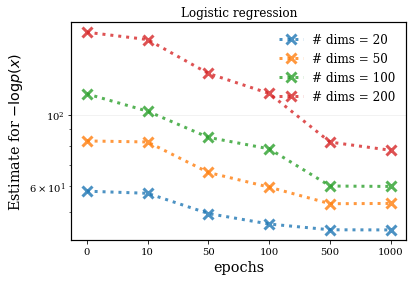

In [27]:
plt.figure(figsize=(6, 4))
for j, dim in enumerate(DIMENSIONS):
    log_likelihood = []
    for i, epoch in enumerate(EPOCHS):
        log_likelihood.append(-results[j][i]['log_likelihood'])
    plt.plot(log_likelihood, label=f'# dims = {dim}', marker='x', ls='dotted', 
             markersize=10, markeredgewidth=3, alpha=0.8)
plt.xticks(ticks=np.arange(len(EPOCHS)), labels=EPOCHS)
plt.xlabel('epochs')
plt.ylabel(r'Estimate for $ - \log p(x)$')
plt.yscale('log')
plt.title(r'Logistic regression')
# plt.legend(frameon=False, fontsize='large', loc='center', bbox_to_anchor=(1.2, 0.5))
plt.legend(frameon=False, fontsize='large', loc='best')
plt.grid(axis='y', alpha=0.2)
plt.savefig(f'{PATH}/logistic_regression_log_likelihood.pdf', bbox_inches='tight')

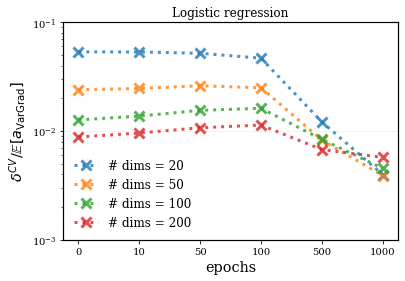

In [28]:
plt.figure(figsize=(6, 4))
for j, dim in enumerate(DIMENSIONS):
    ratio = []
    for i, epoch in enumerate(EPOCHS):
        delta_i = results[j][i]['delta']
        a_vargrad = np.mean(results[j][i]['single_sample_values'])
        
        ratio.append(np.mean(np.abs(delta_i / a_vargrad), axis=0))
        
    plt.plot(ratio, label=f'# dims = {dim}', marker='x', ls='dotted', 
             markersize=10, markeredgewidth=3, alpha=0.8)
plt.xticks(ticks=np.arange(len(EPOCHS)), labels=EPOCHS)
plt.xlabel('epochs')
plt.ylabel(r'$\delta^{CV} / \mathbb{E}[a_{\mathrm{VarGrad}}]$')
plt.yscale('log')
plt.ylim([1e-3, 1e-1])
plt.title(r'Logistic regression')
plt.legend(frameon=False, fontsize='large', loc='best')
plt.grid(axis='y', alpha=0.2)
plt.savefig(f'{PATH}/logistic_regression_ratio.pdf', bbox_inches='tight')

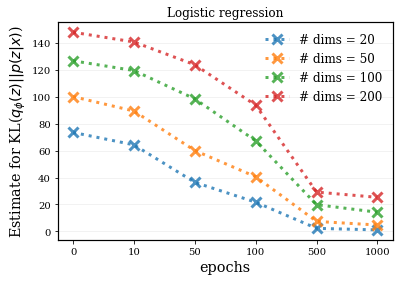

In [29]:
plt.figure(figsize=(6, 4))
for j, dim in enumerate(DIMENSIONS):
    log_likelihood = []
    for i, epoch in enumerate(EPOCHS):
        log_likelihood.append(results[j][i]['log_likelihood'] + np.mean(results[j][i]['single_sample_values']))
    plt.plot(log_likelihood, label=f'# dims = {dim}', marker='x', ls='dotted', 
             markersize=10, markeredgewidth=3, alpha=0.8)
plt.xticks(ticks=np.arange(len(EPOCHS)), labels=EPOCHS)
plt.xlabel('epochs')
plt.ylabel(r'Estimate for KL($q_\phi(z) || p(z|x)$)')
plt.title(r'Logistic regression')
# plt.legend(frameon=False, fontsize='large', loc='center', bbox_to_anchor=(1.2, 0.5))
plt.legend(frameon=False, fontsize='large', loc='best')
plt.grid(axis='y', alpha=0.2)
plt.savefig(f'{PATH}/logistic_regression_KL.pdf', bbox_inches='tight')

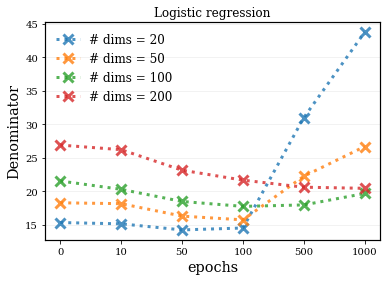

In [30]:
plt.figure(figsize=(6, 4))
for j, dim in enumerate(DIMENSIONS):
    denom = []
    for i, epoch in enumerate(EPOCHS):
        kl = results[j][i]['log_likelihood'] + np.mean(results[j][i]['single_sample_values'])
        logp = results[j][i]['log_likelihood']
        denom.append(np.abs(np.sqrt(kl) - (logp / np.sqrt(kl))))
    plt.plot(denom, label=f'# dims = {dim}', marker='x', ls='dotted', 
             markersize=10, markeredgewidth=3, alpha=0.8)
plt.xticks(ticks=np.arange(len(EPOCHS)), labels=EPOCHS)
plt.xlabel('epochs')
plt.ylabel(r'Denominator')
plt.title(r'Logistic regression')
# plt.legend(frameon=False, fontsize='large', loc='center', bbox_to_anchor=(1.2, 0.5))
plt.legend(frameon=False, fontsize='large', loc='best')
plt.grid(axis='y', alpha=0.2)
plt.savefig(f'{PATH}/logistic_regression_denominator.pdf', bbox_inches='tight')